In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
import cv2
import h5py
import pickle
import sys
import scipy.io
from scipy.spatial import distance
%matplotlib inline

dir = r"C:\Users\aewor\OneDrive - Emory University\Documents\Python\EmanuelLabRotation\2024-01-03_ALC6_day1"
data_path = os.path.join(dir, '02-processed')
npy_path = os.path.join(dir, '00-npy files')
raw_path = os.path.join(dir, '01-raw')

In [2]:
os.environ['COMPUTERNAME']

## Use below code to import analyzeMEA module cloned from github

# #Need to cwd to import the cloned module analyzeMEA
# currPath = os.getcwd()
# print(currPath)

# # Set the working directory to the path of your cloned repository
# analyzeMEA_dir = r"C:\Users\aewor\Documents\GitHub\analyzeMEA"
# os.chdir(analyzeMEA_dir)
# import analyzeMEA

# os.chdir(currPath)

'WORTHY-PC'

## 0.1 Function to import phy-adjusted kilosort data.

### Inputs:
        
1. `data_path` - str with path to kilosort output
2. `depth` - int/float, depth of top electrode site for neuronexus_poly2.prb or depth of bottom electrode site for cnt_h4.prb, in microns (default 250 microns, my typical insertion depth of neuronexus_poly2 probe tip is 1100 microns)        
3. `sampleRate` - int sample rate in Hz (find in params.py if unknown)
    
### Output: Dict with keys
1. `goodSpikes` - ndarray of clusters (unit identities of spikes)
2. `goodSamples` - ndarray of spike samples (time of spike)
3. `goodTimes` - ndarray of spike times (in s)
4. `sampleRate` - int sample rate in Hz (same as input)

### Not yet implemented
1. ...
<!-- 1. `unitPosXY` - tuple of two ndarrays, (X center of mass, Y center of mass)
2. `depthIndices` - index of good units in the order of their depth
3. `depths` - depth of site (taking into account depth of probe)
4. `layers` - the cortical layer to which the depth corresponds
5. `units` - list of all units included in goodSpikes -->

In [19]:
def importphy(folderpath, tipDepth=4000, sampleRate=30000):
    """
    Import kilosort/phy2 outputs

        ## Inputs:
        1. `folderpath` - str with path to kilosort output
        2. `tipDepth` - int/float, depth of the shank tip in microns (Reading of D axis given by sensapex micromanipulator)
        3. `sampleRate` - int sample rate in Hz (find in params.py if unknown)
            
        ## Output: Dict with keys
        1. `sampleRate` - int sample rate in Hz (same as input)
        2. `goodSpikes` - ndarray of clusters (unit identities of spikes)
        3. `goodSamples` - ndarray of spike samples (time of spike)
        4. `goodTimes` - ndarray of spike times (in s)
        5. `clusterIDs` - ndarray of unit index as listed in the Kilosort/Phy output
        6. `goodIDs` - ndarray of all units included in goodSpikes
        7. `depths` - ndarray of recording site depth, order match with `clusterID` (counting the depth of shank)
        8. `nSpikes` - ndarray of number of spikes 

        ## Not yet implemented
        1. `unitPosXY` - tuple of two ndarrays, (X center of mass, Y center of mass)
        2. `depthIndices` - index of good units in the order of their depth
        3. `layers` - the cortical layer to which the depth corresponds
        4. 'waveforms of unit at its best site'
    """
    # parameters
    tipLength = 175 # the tip length of neuropixel 1.0 [unit: µm]

    # import the Kilosort data
    clusterInfo = pd.read_csv(folderpath+'/cluster_info.tsv',sep='\t')
    spikeClusters = np.load(folderpath+'/spike_clusters.npy')
    spikeTimes = np.load(folderpath+'/spike_times.npy')

    # apply label from manual curation 
    clusterInfo.loc[clusterInfo['group'] == 'good', 'KSLabel'] = 'good'

    # store units with good qualities
    try:
        goodIDs = np.array(clusterInfo['id'][clusterInfo['KSLabel'] == 'good'])
    except KeyError:
        goodIDs = np.array(clusterInfo['cluster_id'][clusterInfo['KSLabel'] == 'good'])
    
    # compute the depth
        siteDepth = tipDepth - tipLength - np.array(clusterInfo['depth'])
        if any(depth < 0 for depth in siteDepth):
            print("Warning: Negative depth value found, changing to 0.")
            siteDepth = [0 if depth < 0 else depth for depth in siteDepth]

    # write the output
    outDict = {}
    outDict['sampleRate'] = sampleRate
    outDict['goodSpikes'] = spikeClusters[np.array([n in goodIDs for n in spikeClusters])]
    outDict['goodSamples'] = np.int64(spikeTimes[np.array([n in goodIDs for n in spikeClusters])].reshape(-1))
    outDict['goodTimes'] = outDict['goodSamples']/sampleRate
    outDict['clusterIDs'] = np.array(clusterInfo['cluster_id']) ## to get a list of cluster ids
    outDict['goodIDs'] = goodIDs
    outDict['depths'] =  siteDepth
    outDict['nSpikes'] = np.array(clusterInfo['n_spikes']) ## to get number of spikes 
    #outDict['depthIndices'] = np.argsort(clusterInfo['depth']) ## to get an index to use for sorting by depth

    # print the number of good neurons
    print("Number of neurons passing the quality check: {}".format(len(goodIDs)))

    # report the sampling frequency
    print("Sampling frequency: {} Hz.".format(outDict['sampleRate']))
    
    return outDict

In [20]:
spikeDict = importphy(data_path, tipDepth=4050, sampleRate=30000)

goodSamples = spikeDict['goodSamples']
goodSpikes = spikeDict['goodSpikes']
goodTimes = spikeDict['goodTimes']
sampleRate = spikeDict['sampleRate']
depths = spikeDict['depths']

Number of neurons passing the quality check: 201
Sampling frequency: 30000 Hz.


In [ ]:
def importnpy(folderpath):
    """
    Import kilosort/phy2 outputs

        ## Inputs:
        1. `folderpath` - str with path to folder containing numpy arrays from NP_Optical trials
            
        ## Output: Dict with keys
        1. `sampleRate` - int sample rate in Hz (same as input)
        2. `mechTrialForce` - array of all trials and their forces

        ## Not yet implemented
        1. `unitPosXY` - tuple of two ndarrays, (X center of mass, Y center of mass)
    """
    import os
    import numpy as np
    import re

    data_files = [item for item in os.listdir(folderpath)]
    mech_files = [file for file in data_files if 'mC_ai_data' in file]


    # Define a sorting function based on all digits after the last underscore
    def sort_key(file):
        match = re.search(r'_(\d+).npy$', file)
        return int(match.group(1)) if match else float('inf')

    # Sort the files using the custom sorting function
    sorted_files = sorted(mech_files, key=sort_key)


    mechTrialForce = []
    for sorted_file in sorted_files:
        match = re.search(r'_(\d+)mN_', sorted_file)
        force = int(match.group(1)) if match else None
        mechTrialForce.append(force)

    
    #Exports
    outDict = {}
    outDict['sampleRate'] = sampleRate
    outDict['mechTrialForce'] = mechTrialForce

    return outDict

In [ ]:
npy_path

In [ ]:
npyDict = importnpy(npy_path)

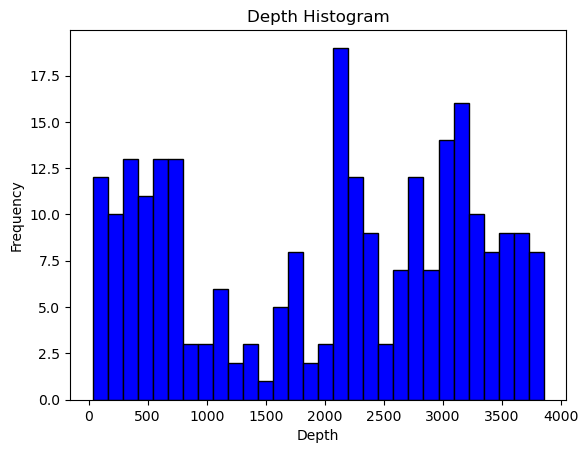

In [21]:
# Plotting the histogram
plt.hist(depths, bins=30, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.title('Depth Histogram')

# Display the histogram
plt.show()

## 0.2 Plotting all units to ensure proper import.

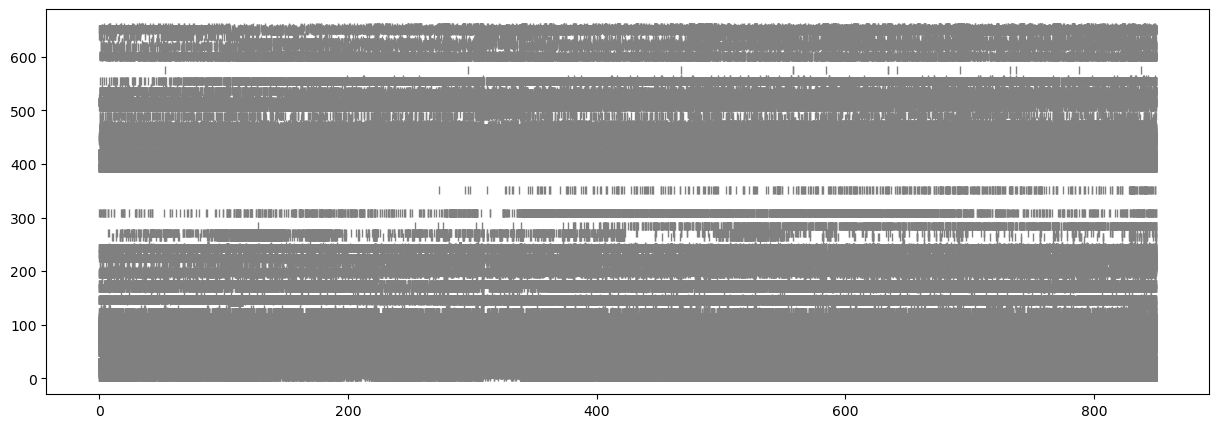

In [22]:
ltime = 0 # in seconds
rtime = 850 # in seconds

#plt.plot(goodtimes,goodspikes,'|')
plt.figure(figsize=(15,5))
plt.plot(goodTimes[(goodTimes > ltime) & (goodTimes < rtime)],goodSpikes[(goodTimes > ltime) & (goodTimes < rtime)],'|',color='gray')

In [23]:
#initial z-score for mech
# Define trial parameters
trial_duration = 4.997  # seconds
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 172
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(trial_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration)
    end_index = (i + 1) * int(sampleRate * trial_duration)

    # # Find indices within the specified range
    # indices_within_range = [i for i, val in enumerate(goodSamples) if start_index <= val <= end_index]

    # # Extract corresponding spike samples for all units
    # trial_spikes_all_units = [goodSamples[i] for i in indices_within_range]
    trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_all_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in the first 2 seconds
    baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor) - 1])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]


[[22. 22. 22. ... 22. 22. 22.]
 [22. 22. 22. ... 22. 22. 22.]
 [20. 20. 20. ... 20. 20. 20.]
 ...
 [35. 35. 35. ... 35. 35. 35.]
 [35. 35. 35. ... 35. 35. 35.]
 [35. 35. 35. ... 35. 35. 35.]]


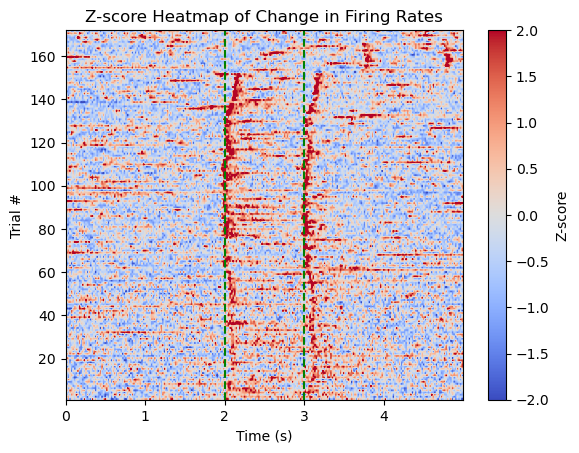

In [24]:
from scipy.stats import zscore
from scipy.stats import zmap


# Z-score the change in firing rates
z_scored_change = zscore(change_in_firing_rates, axis=1)
#z_scored_change = zmap(change_in_firing_rates, baseline_firing_rates, axis=0)
print(baseline_firing_rates)

# Plotting
time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-2, vmax=2)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = stim_onset
hold_duration = stim_hold
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates')
plt.show()

#takes about 1.5 minutes

In [125]:
#y axis is units instead of trials
# Define trial parameters
trial_duration = 4.997  # seconds
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 172
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(trial_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))  # Adjusted size
stimulation_signal = np.zeros((num_trials, int(sampleRate * trial_duration)))

# Create a dictionary to store firing rates for each unit
unit_firing_rates = {}
unit_baseline_rates = {}

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration)
    end_index = (i + 1) * int(sampleRate * trial_duration)

    # Find indices within the specified range
    indices_within_range = [i for i, val in enumerate(goodSamples) if start_index <= val <= end_index]

    # Extract corresponding spike samples and unit IDs for all units
    trial_spikes_all_units = [goodSpikes[i] for i in indices_within_range]

    # Calculate firing rates for each unit using np.histogram
    for unit_id in set(trial_spikes_all_units):
        unit_indices = [idx for idx, val in enumerate(trial_spikes_all_units) if val == unit_id]
        unit_spikes = [goodSamples[indices_within_range[idx]] for idx in unit_indices]

        firing_rates, bins = np.histogram(unit_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))
        unit_firing_rates.setdefault(unit_id, []).append(firing_rates[:num_bins])

        # Calculate the average firing rate in the first 2 seconds
        baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor) - 1])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
        unit_baseline_rates.setdefault(unit_id, []).append(baseline_firing_rate[:num_bins])

#takes about 1.5 minutes


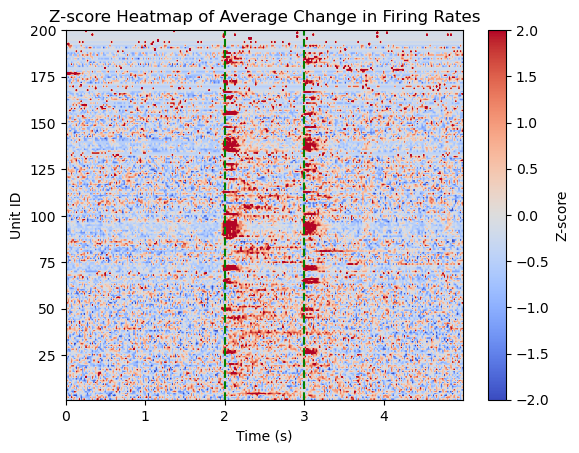

In [126]:
# Calculate the average change in firing rate for each unit across trials
average_unit_firing_rates = {unit_id: np.mean(unit_rates, axis=0) for unit_id, unit_rates in unit_firing_rates.items()}
average_unit_baseline_rates = {unit_id: np.mean(base_rates, axis=0) for unit_id, base_rates in unit_baseline_rates.items()}

# Convert the dictionary values to a 2D array for plotting
average_change_in_firing_rates = np.array(list(average_unit_firing_rates.values()))
average_change_in_baseline_rates = np.array(list(average_unit_baseline_rates.values()))

# Z-score the change in firing rates
#z_scored_change = zmap(average_change_in_firing_rates, average_change_in_baseline_rates, axis=0)
z_scored_change = zscore(average_change_in_firing_rates, axis=1)


# Plotting
time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
unit_axis = list(average_unit_firing_rates.keys())

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, len(unit_axis)], cmap='coolwarm', origin='lower', vmin=-2, vmax=2)  # Centered colormap


# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stim_onset + stim_hold , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit ID')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Average Change in Firing Rates')
plt.show()

In [129]:
#Select enhanced units
# Define the time range in seconds
start_time = 2
end_time = 2.4

# Convert the time range to bin indices
start_bin = int(start_time / bin_factor)
end_bin = int(end_time / bin_factor)

# Filter units with z-score over 3 in the specified time range
significant_units = [unit_id for unit_id, z_scores in average_unit_firing_rates.items() if any(z_scores[start_bin:end_bin] > .3)]

# Print the list of significant units
print(len(significant_units))
print(significant_units)

57
[3, 516, 8, 10, 11, 15, 18, 22, 24, 30, 555, 56, 59, 64, 69, 70, 71, 72, 79, 81, 84, 87, 89, 95, 97, 99, 101, 108, 112, 114, 650, 652, 142, 176, 223, 224, 228, 233, 244, 393, 395, 396, 404, 409, 410, 421, 446, 507, 27, 216, 394, 111, 525, 221, 35, 285, 158]


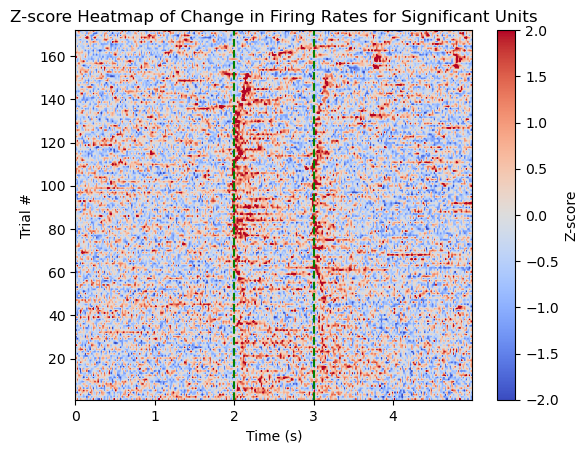

In [130]:
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt

# Define trial parameters
trial_duration = 4.997  # seconds
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 172
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(trial_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))  # Adjusted size

# Process each trial for significant units only
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration)
    end_index = (i + 1) * int(sampleRate * trial_duration)

    # Find indices within the specified range
    indices_within_range = [i for i, val in enumerate(goodSamples) if start_index <= val <= end_index]

    # Extract corresponding spike samples and unit IDs for significant units only
    trial_spikes_significant_units = [goodSamples[i] for i in indices_within_range if goodSpikes[i] in significant_units]

    # Calculate firing rates for each significant unit using np.histogram
    for unit_id in significant_units:
        unit_indices = [idx for idx, val in enumerate(trial_spikes_significant_units) if goodSpikes[indices_within_range[idx]] == unit_id]
        unit_spikes = [trial_spikes_significant_units[idx] for idx in unit_indices]

        firing_rates, bins = np.histogram(unit_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))
        change_in_firing_rates[i, :] += firing_rates[:num_bins]  # Accumulate firing rates for each bin

# Z-score the change in firing rates for significant units only
z_scored_change = zscore(change_in_firing_rates, axis=1)

# Plotting (similar to the original code)
time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-2, vmax=2)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = stim_onset
hold_duration = stim_hold
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates for Significant Units')
plt.show()

#takes about 1.5 minutes

In [ ]:
# Separate data for each applied force
unique_forces = np.unique(mechTrialForce)  # Assuming stimulus_force is the array containing force values for each trial

for force in unique_forces:
    # Indices of trials with the current force level
    force_indices = np.where(mechTrialForce == force)[0]

    # Initialize arrays to store firing rates and stimulation signal for the current force level
    change_in_firing_rates_force = np.zeros((len(force_indices), int(trial_duration / bin_factor) - 1))
    stimulation_signal_force = np.zeros((len(force_indices), int(sampleRate * trial_duration)))

    # Process each trial for the current force level
    for i, trial_index in enumerate(force_indices):
        start_index = trial_index * int(sampleRate * trial_duration)
        end_index = (trial_index + 1) * int(sampleRate * trial_duration)

        # Find indices within the specified range
        indices_within_range = [i for i, val in enumerate(goodSamples) if start_index <= val <= end_index]

        # Extract corresponding spike samples for significant units only
        trial_spikes_significant_units = [goodSamples[i] for i in indices_within_range if goodSpikes[i] in significant_units]

        # Calculate firing rates for each significant unit using np.histogram
        for unit_id in significant_units:
            unit_indices = [idx for idx, val in enumerate(trial_spikes_significant_units) if goodSpikes[indices_within_range[idx]] == unit_id]
            unit_spikes = [trial_spikes_significant_units[idx] for idx in unit_indices]

            firing_rates, bins = np.histogram(unit_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))
            change_in_firing_rates_force[i, :] += firing_rates[:num_bins]  # Accumulate firing rates for each bin

    # Z-score the change in firing rates for the current force level
    z_scored_change_force = zscore(change_in_firing_rates_force, axis=1)

    # Plotting for the current force level
    time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
    trial_axis = np.arange(1, len(force_indices) + 1)

    # Create a z-score heatmap for the current force level
    plt.imshow(z_scored_change_force, aspect='auto', extent=[0, trial_duration, 1, len(force_indices)], cmap='coolwarm', origin='lower', vmin=-2, vmax=2)  # Centered colormap

    # Add stimulation onset, hold, and ramp-down lines
    stimulation_onset = stim_onset
    hold_duration = stim_hold
    plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
    plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

    plt.xlabel('Time (s)')
    plt.ylabel('Trial #')
    plt.colorbar(label='Z-score')
    plt.title(f'Z-score Heatmap of Change in Firing Rates for Force Level {force}')
    plt.show()

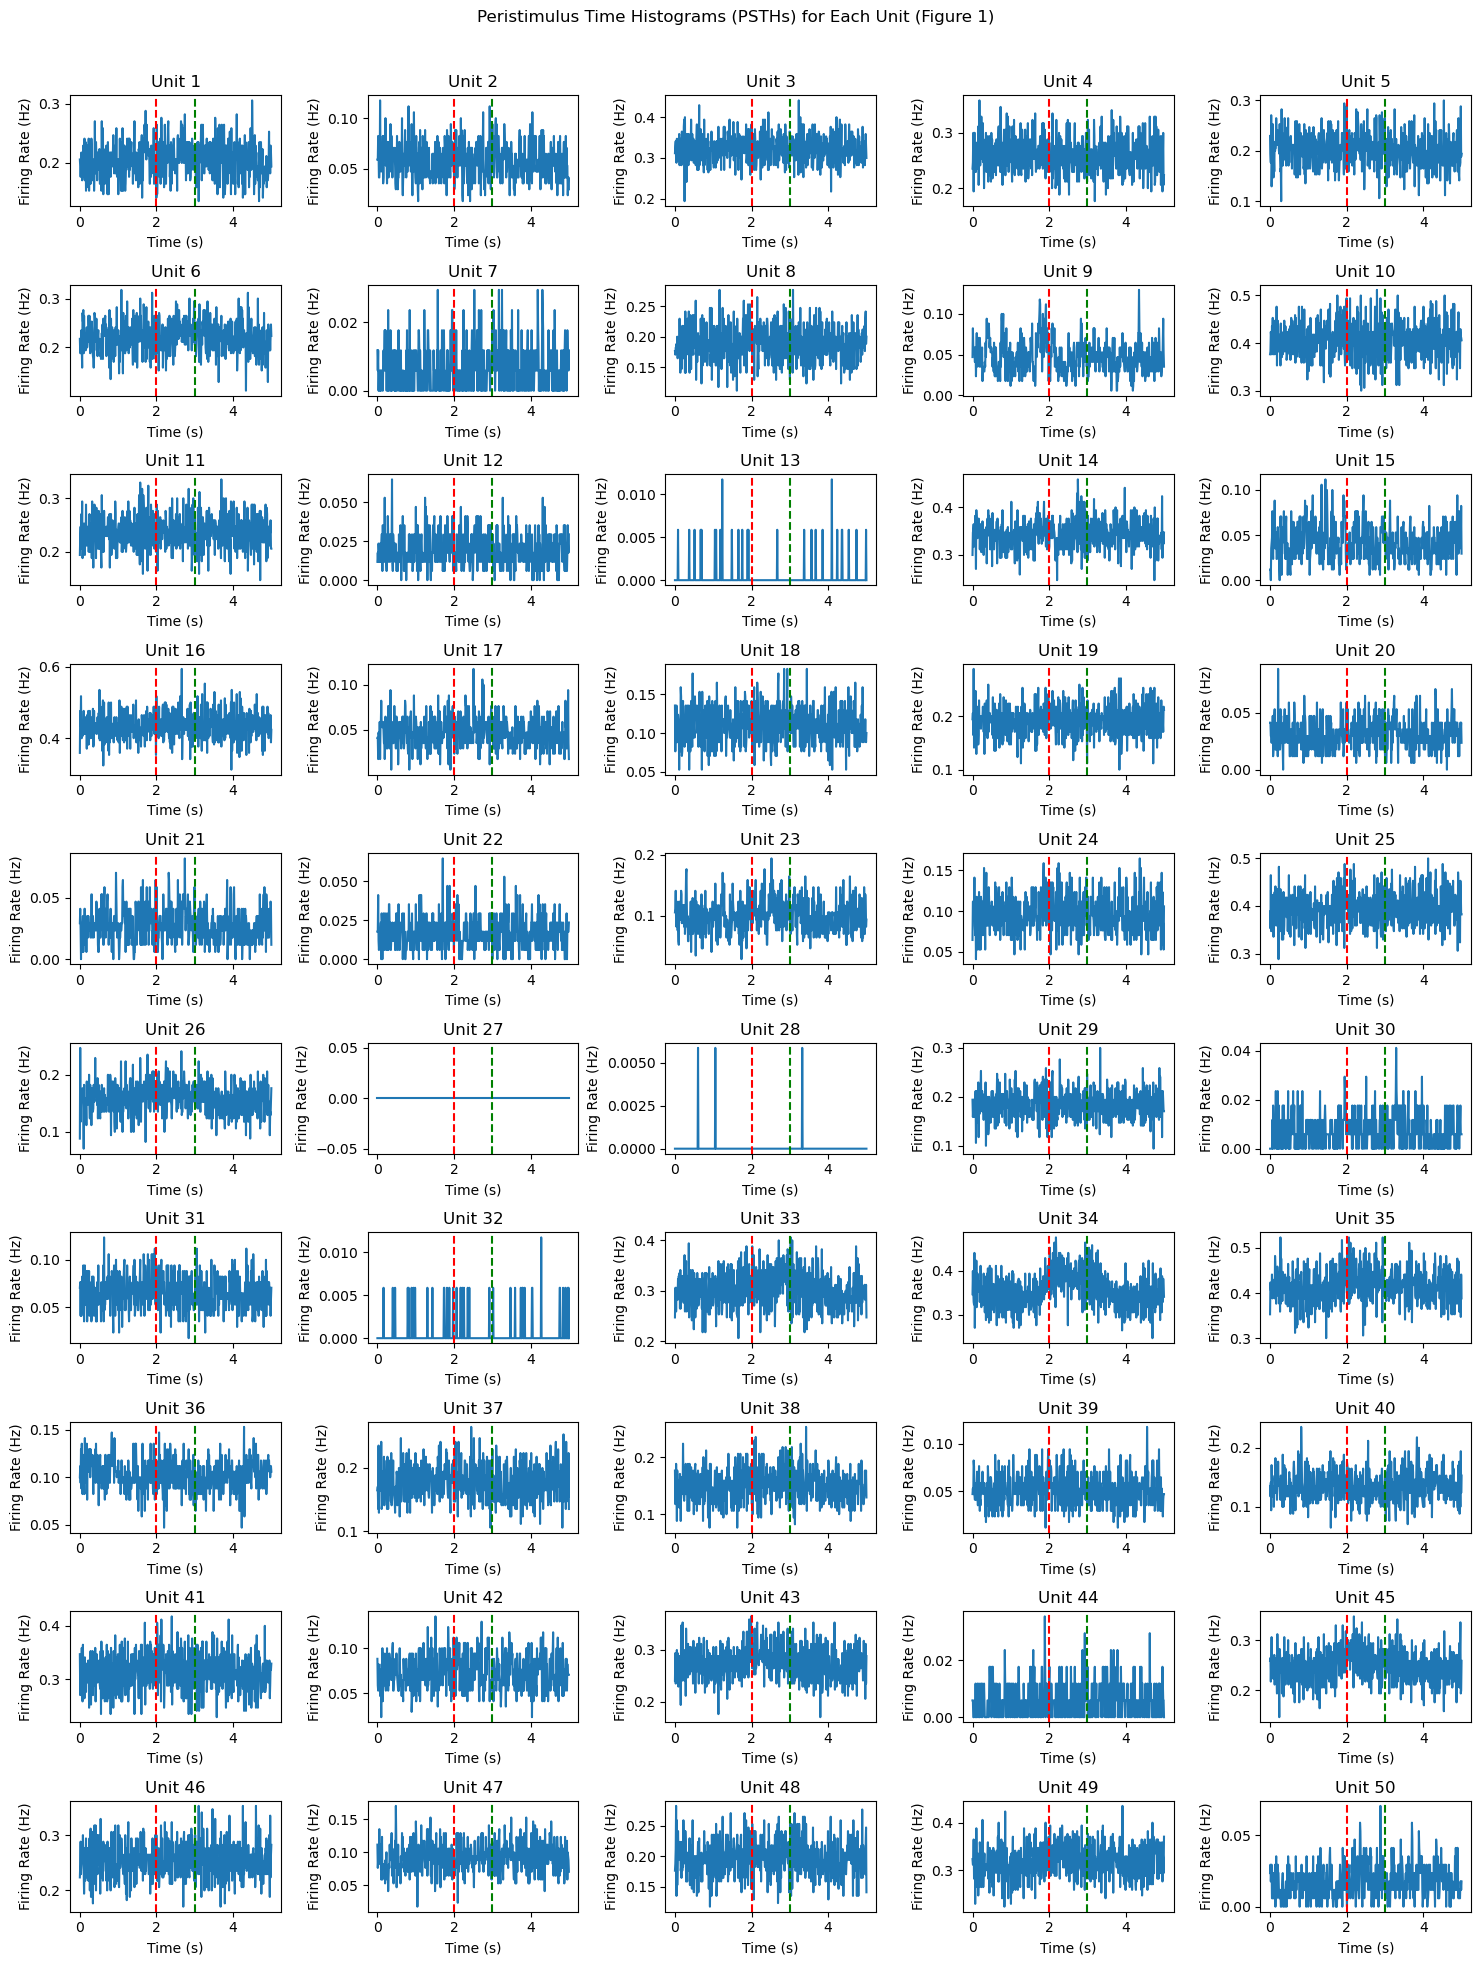

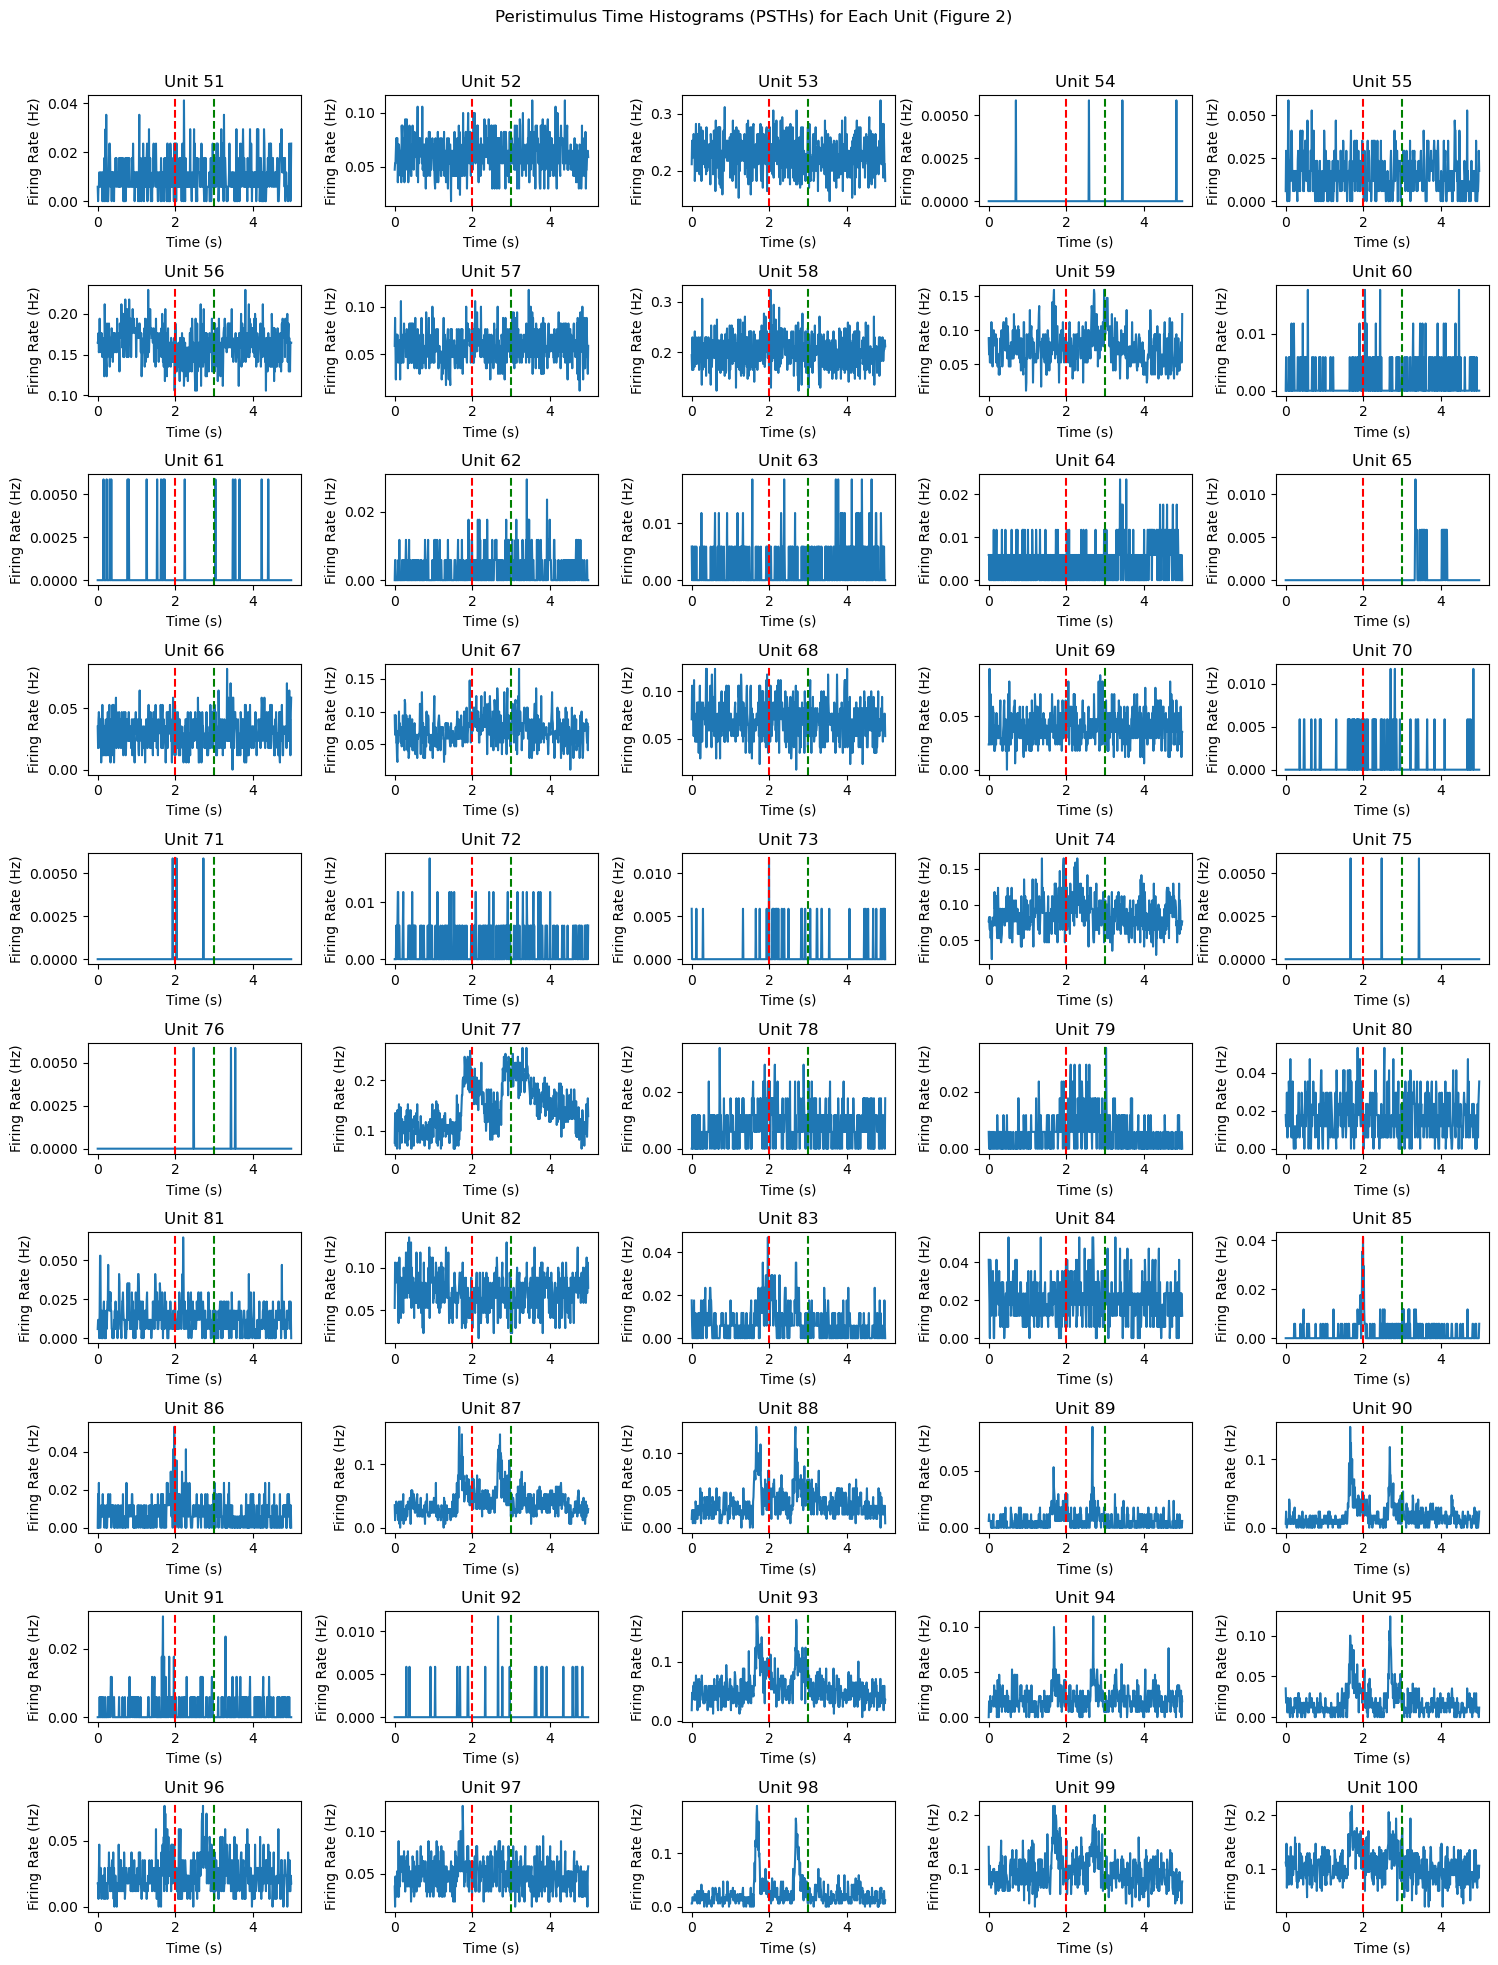

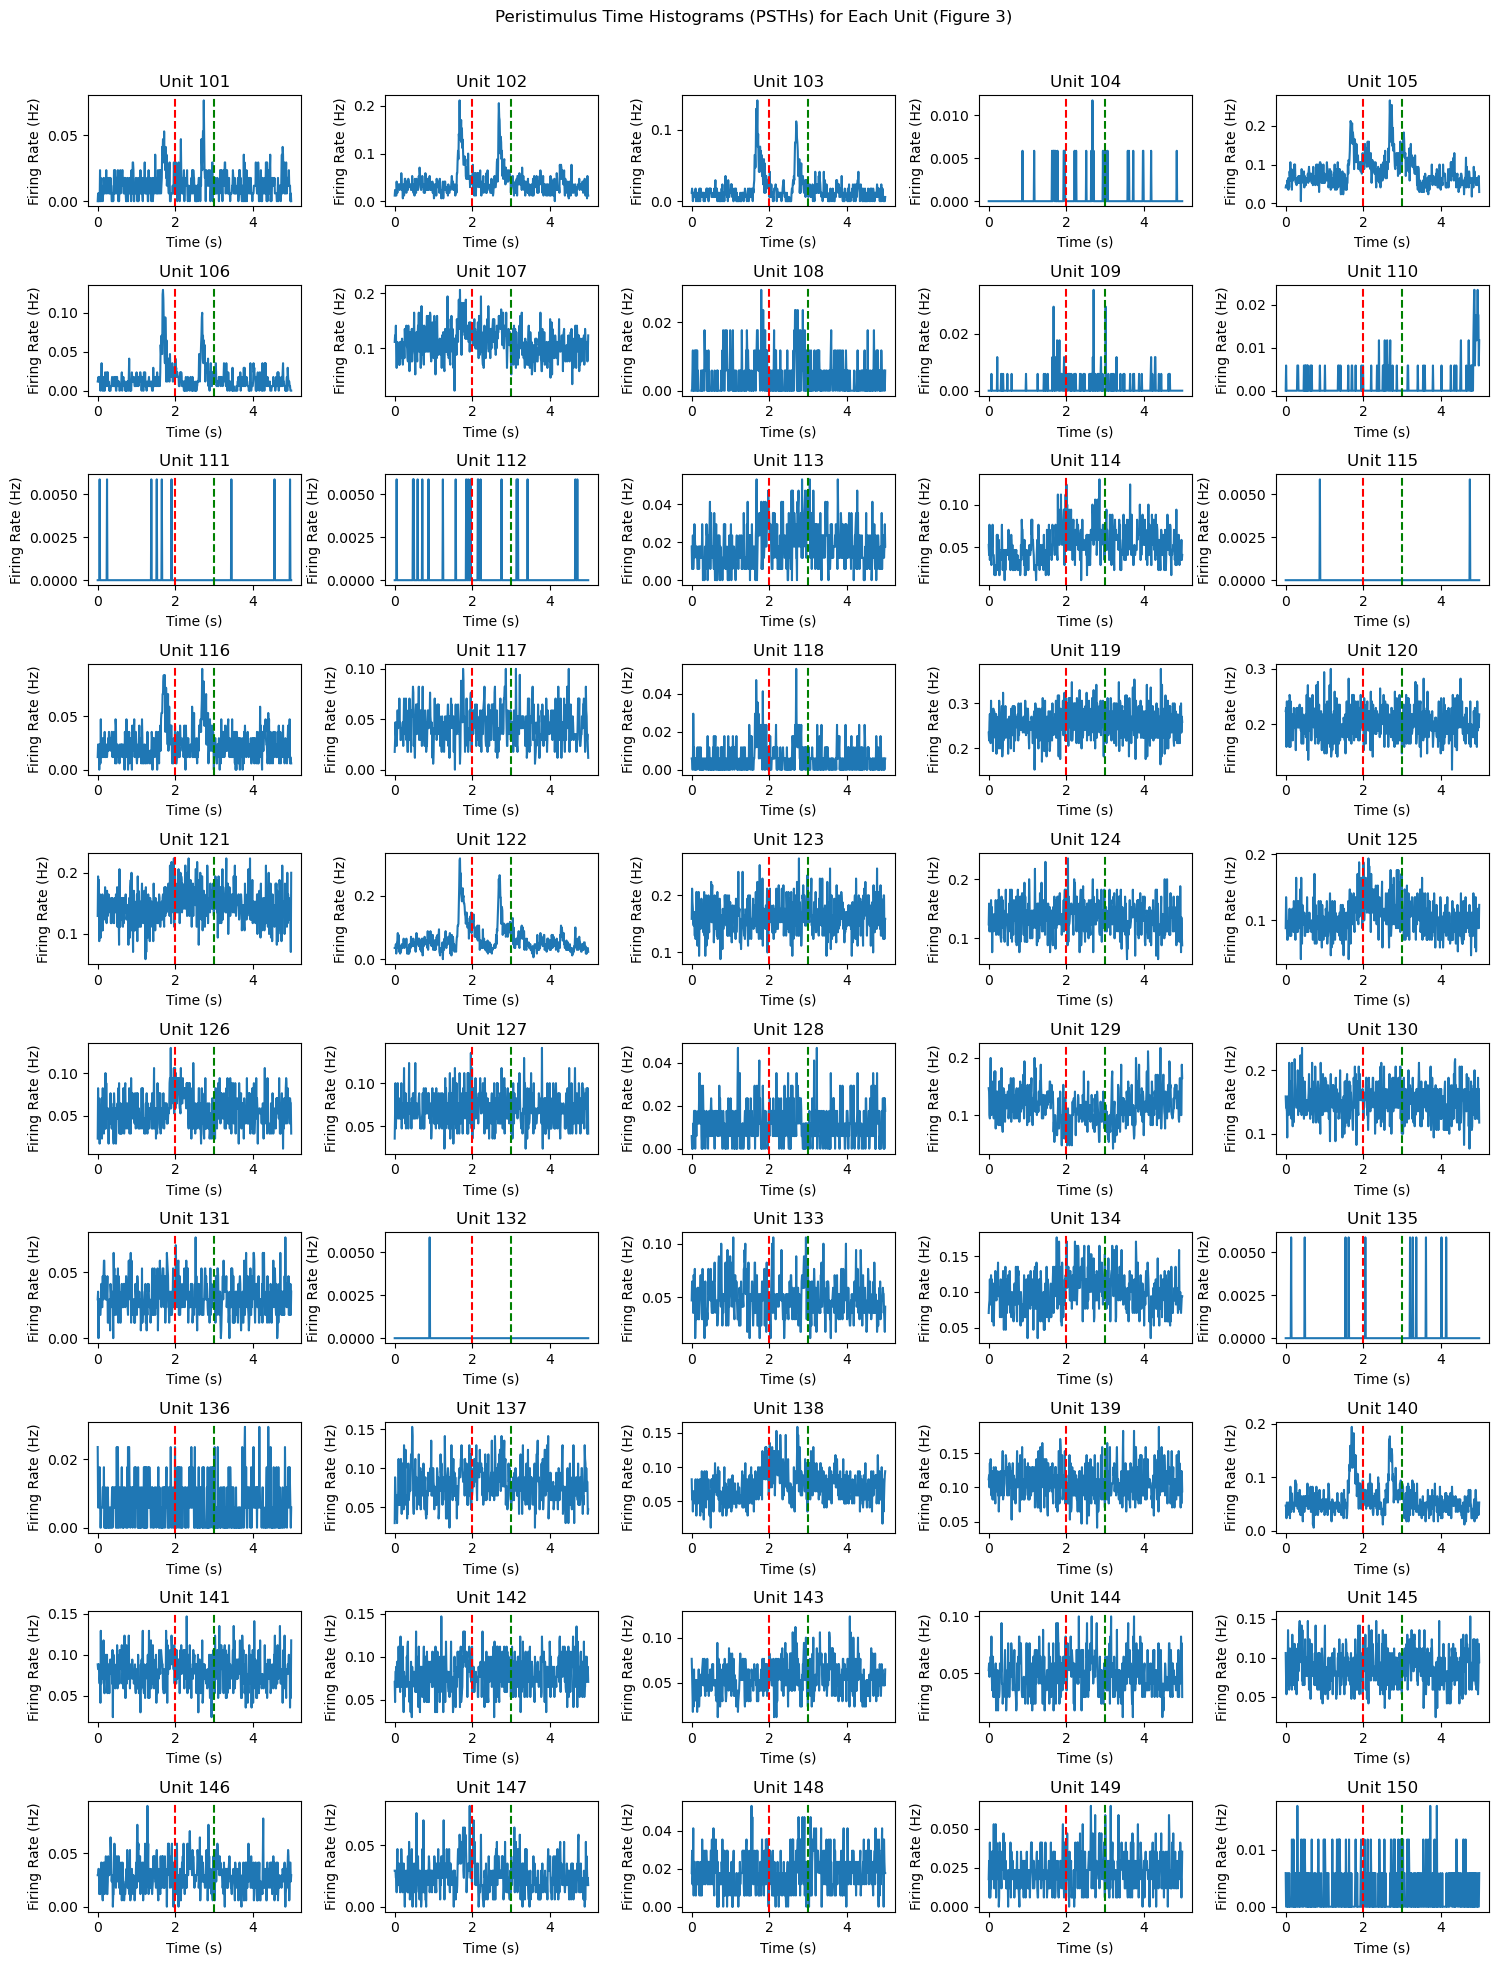

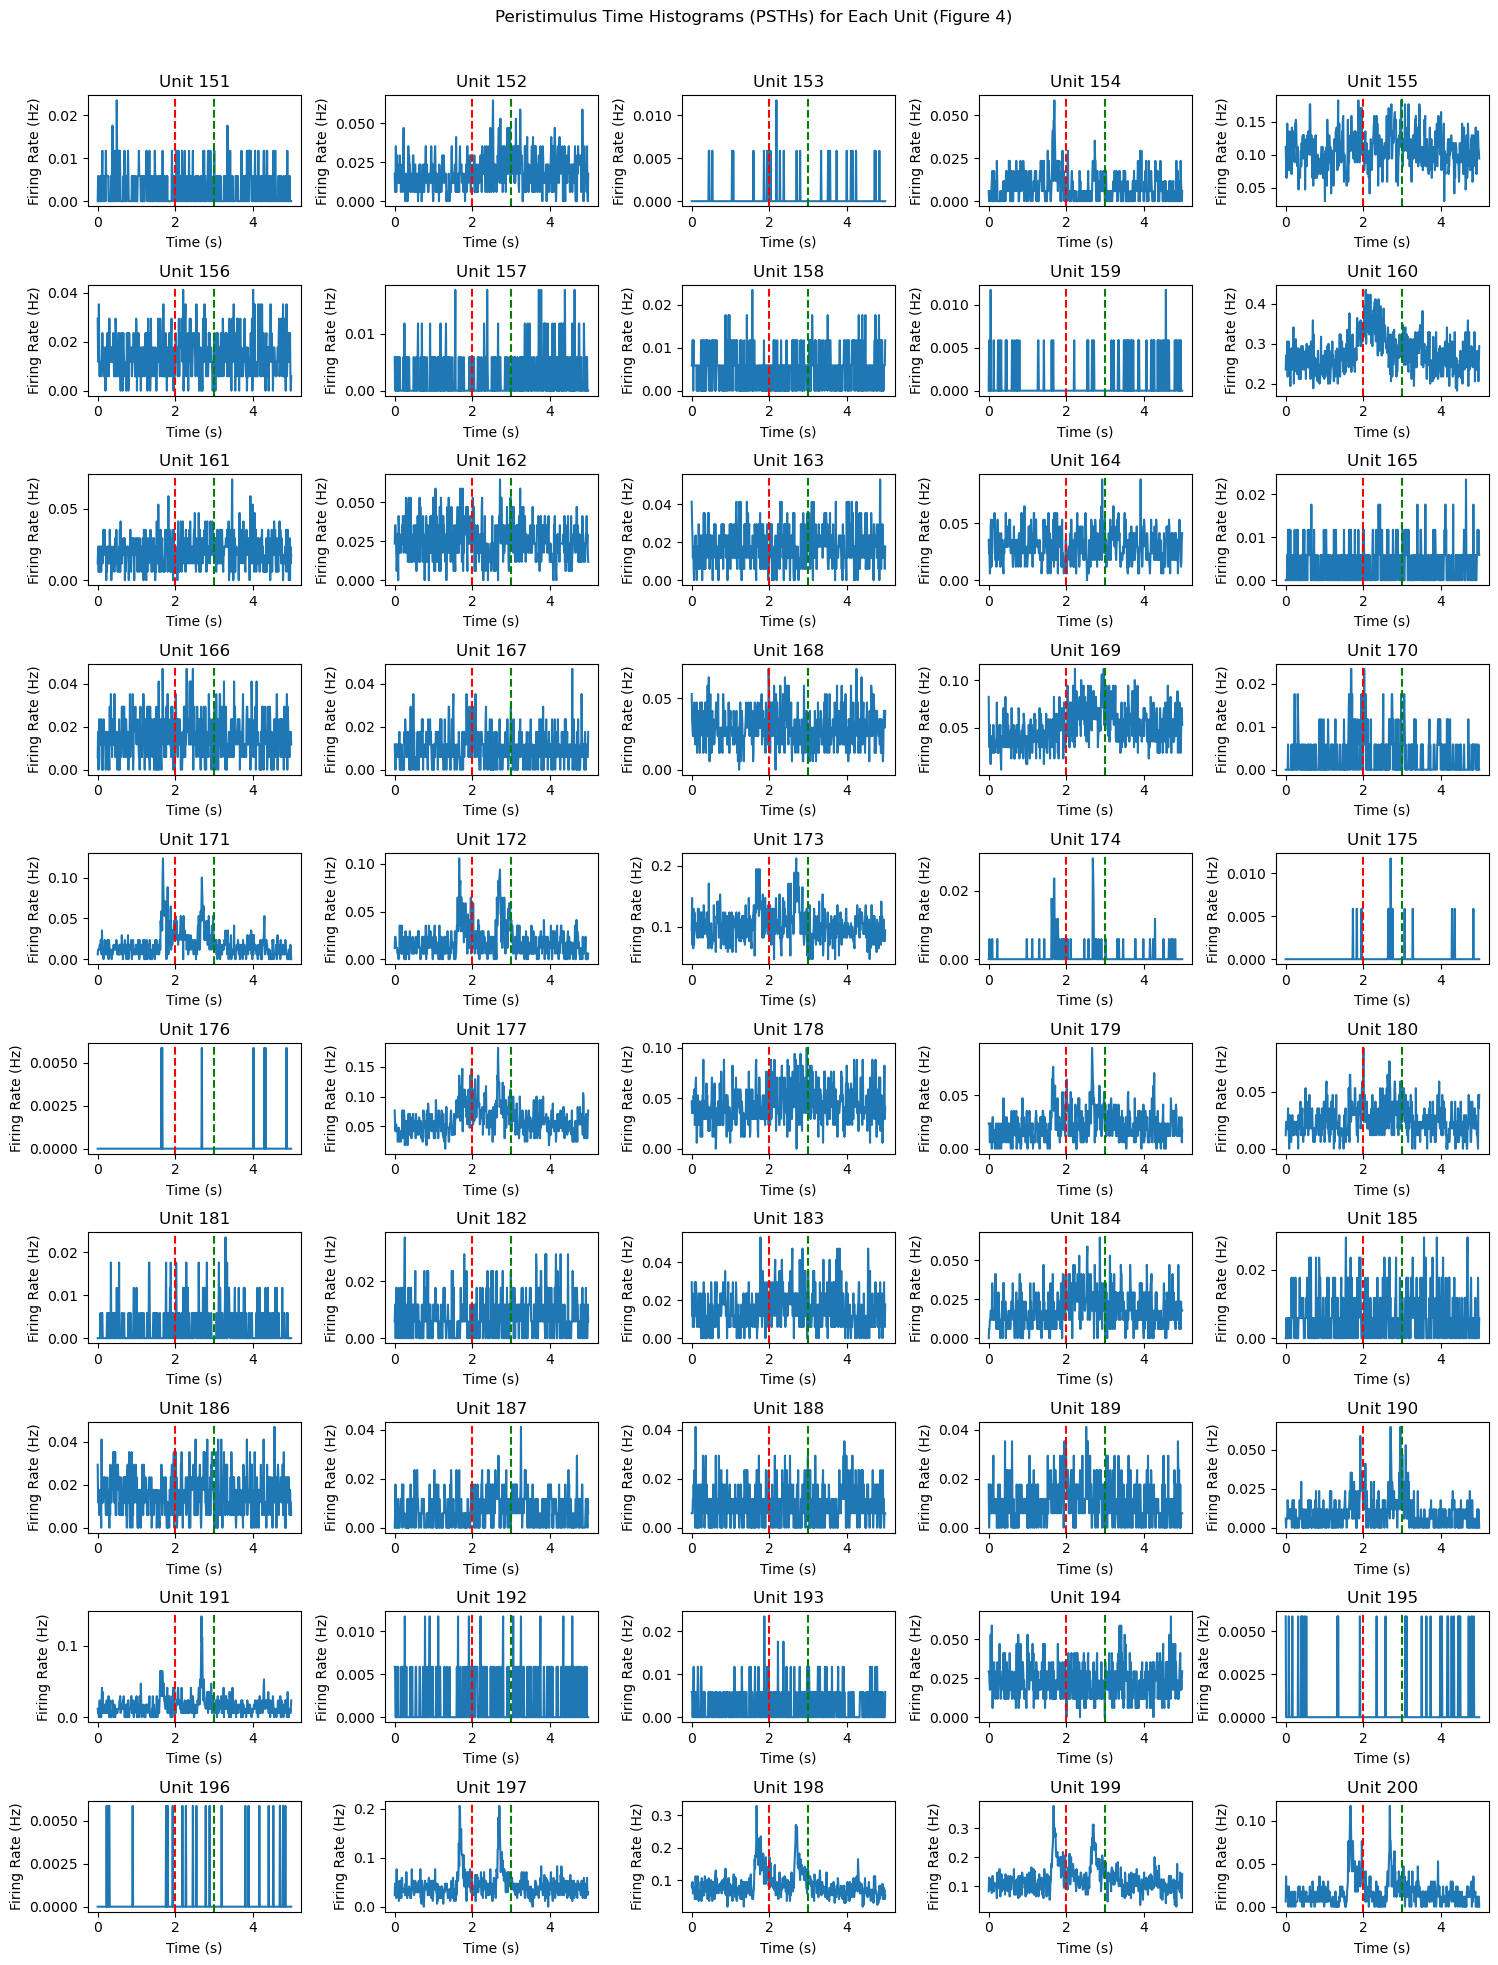

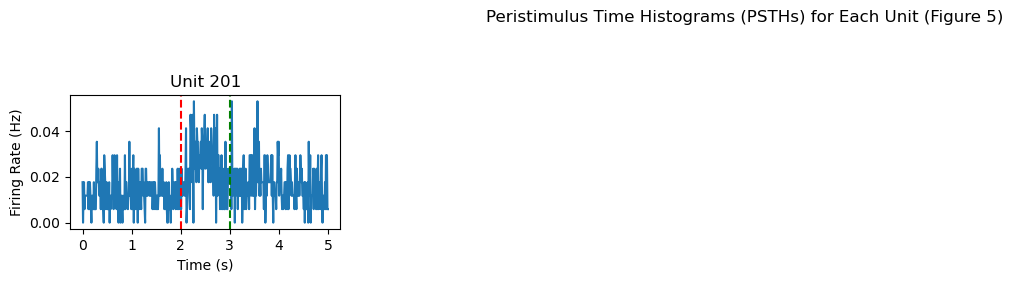

In [37]:
def calculate_psth(unit_spikes, num_trials, trial_duration, sample_rate):
    bin_size = int(sample_rate * 0.01)
    num_bins = int(trial_duration / 0.01) - 1

    trial_firing_rates = np.zeros((num_trials, num_bins))

    for i in range(num_trials):
        start_index = i * int(sample_rate * trial_duration)
        end_index = (i + 1) * int(sample_rate * trial_duration)

        indices_within_range = [j for j, val in enumerate(unit_spikes) if start_index <= val <= end_index]
        trial_spikes = [unit_spikes[j] for j in indices_within_range]

        firing_rates, bins = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

        if len(firing_rates) == num_bins + 1:
            firing_rates = firing_rates[:-1]

        trial_firing_rates[i, :] = firing_rates

    mean_psth = np.mean(trial_firing_rates, axis=0)
    return mean_psth

# Define trial parameters
num_trials = 170

# Initialize arrays to store PSTHs
psth_data = []

# Process each unit
for unit_id in np.unique(goodSpikes):
    unit_spikes = [goodSamples[i] for i, unit in enumerate(goodSpikes) if unit == unit_id]
    mean_psth = calculate_psth(unit_spikes, num_trials, trial_duration, sampleRate)
    psth_data.append(mean_psth)

# Plotting PSTHs in subplots with a limit of 50 subplots per figure
num_units = len(psth_data)
plots_per_figure = 50
num_figures = int(np.ceil(num_units / plots_per_figure))

for figure_num in range(num_figures):
    plt.figure(figsize=(15, 20))
    

    for i in range(plots_per_figure):
        unit_index = figure_num * plots_per_figure + i
        if unit_index < num_units:
            plt.subplot(10, 5, i + 1)
            plt.plot(np.linspace(0, trial_duration, len(psth_data[unit_index])), psth_data[unit_index])
            plt.title(f'Unit {unit_index + 1}')
            plt.xlabel('Time (s)')
            plt.ylabel('Firing Rate (Hz)')

            # Add stimulation onset, hold, and ramp-down lines
            stimulation_onset = stim_onset
            hold_duration = stim_hold
            plt.axvline(x=stimulation_onset, linestyle='--', color='red', label='Stimulation Onset')
            plt.axvline(x=stimulation_onset + hold_duration, linestyle='--', color='green', label='Ramp Down')

    plt.suptitle(f'Peristimulus Time Histograms (PSTHs) for Each Unit (Figure {figure_num + 1})')
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout for the suptitle
    plt.show()

## 0.4 Plotting for physio experiment

In [138]:
settings = {
    'task_name' : 'physiologicalLaser',
    
    'xMirror_output': 'PXI1Slot2/ao0',
    'yMirror_output': 'PXI1Slot2/ao1',
    'laser_output': '/PXI1Slot2/port0/line0',
    'sync': '/PXI1Slot2/port0/line1', #output to trigger NP recording

    'Fs': 30000,  # in samples/s
    'xV' : 7.8, # in Volts. Fixed voltage for mirror's x-axis
    'yV' : 3.2, # in Volts. Fixed voltage for mirror's y-axis

    'trace_oi' : 4, # number (X) for trace of interest from "SA-LTMR example traces/saltmr_trace{X}.npy"
    'laser_duration' : 0.0003,  # seconds
    'train_duration' : 0.5, # seconds
    'rest_duration' : 5, # seconds
    'trial_buffer' : 1, # seconds
    'trial_repeats' : 50 # number of trains to pass (100 takes ~10 minutes; default = 50)
}

# calculate trial_duration and load example trace_array
trial_duration = (2 * settings['trial_buffer']) + (settings['trial_repeats'] * (settings['train_duration'] + settings['rest_duration']))
print(trial_duration)

277.0


In [39]:
physio = r"C:\Users\aewor\OneDrive - Emory University\Documents\Python\EmanuelLabRotation\2024-01-03_ALC6_day1\00-npy files\physioLaser_20240103_134825_ao_data.npy"
physfile = np.load(physio)
print(len(physfile[0]))
print(((len(physfile[0])/30000)-2)/5)

8160000
54.0


In [57]:
acrec = r"C:\Users\aewor\OneDrive - Emory University\Documents\Python\EmanuelLabRotation\2024-01-03_ALC6_day1\00-npy files\acRecField_20240103_134321_ao_data.npy"
acrecfile = np.load(acrec)
print(len(acrecfile[0]))
print(((len(acrecfile[0])/30000)-2)/5)

3600000
23.6


In [69]:
settings = {
    'task_name' : 'pulsedLaser',
    
    'xMirror_output': 'PXI1Slot2/ao0',
    'yMirror_output': 'PXI1Slot2/ao1',
    'laser_output': '/PXI1Slot2/port0/line0',
    'sync': '/PXI1Slot2/port0/line1', #output to trigger NP recording

    'Fs': 30000,  # in samples/s
    'xV' : 7.8, # in Volts. Fixed voltage for mirror's x-axis
    'yV' : 3.2, # in Volts. Fixed voltage for mirror's y-axis

    'laser_duration' : 0.0003,  # seconds
    'laser_frequency' : 40, # Hz (for sustained pulse, equate to settings['Fs']). **Run 5, 20, and 40Hz for full set**
    'train_duration' : 0.5, # seconds
    'rest_duration' : 5, # seconds
    'trial_buffer' : 1, # seconds
    'trial_repeats' : 50 # number of trains to pass (100 takes ~10 minutes; default = 50)
}


# calculate trial_duration
trial_duration = (2 * settings['trial_buffer']) + (settings['trial_repeats'] * (settings['train_duration'] + settings['rest_duration']))

train_onsets = np.arange((settings['trial_buffer']), (trial_duration), ((settings['train_duration'] + settings['rest_duration']))) * settings['Fs']

intervals = []

for i in range(len(train_onsets)-1):
    interval = train_onsets[i+1] - train_onsets[i]
    intervals.append(interval)

print(train_onsets)
print(trial_duration*30000)
print(np.unique(intervals))
print(165000/30000)

[  30000.  195000.  360000.  525000.  690000.  855000. 1020000. 1185000.
 1350000. 1515000. 1680000. 1845000. 2010000. 2175000. 2340000. 2505000.
 2670000. 2835000. 3000000. 3165000. 3330000. 3495000. 3660000. 3825000.
 3990000. 4155000. 4320000. 4485000. 4650000. 4815000. 4980000. 5145000.
 5310000. 5475000. 5640000. 5805000. 5970000. 6135000. 6300000. 6465000.
 6630000. 6795000. 6960000. 7125000. 7290000. 7455000. 7620000. 7785000.
 7950000. 8115000. 8280000.]
8310000.0
[165000.]
5.5


In [80]:
mech_duration = 167 * 4.997 * 30000 #duration in samples
acRecField_duration = 3600000 #duration in samples
physio_duration = 8160000 #duration in samples

physio_start = mech_duration + acRecField_duration #start sample number
physio_end = physio_start + physio_duration #end sample number

physio_start_index = physio_start #+ int(1 * 30000) #add in buffer time


pulse_start = physio_start + physio_duration
pulse_end = pulse_start + physio_duration
print(physio_start_index)


28634970.0


In [83]:
#initial z-score for mech
# Define trial parameters
trial_duration = 5.5  # seconds
stim_onset = 0.1  # second
stim_ramp_down = 0.6  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 150
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(trial_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration) + pulse_start
    end_index = (i + 1) * int(sampleRate * trial_duration) + pulse_start

    # # Find indices within the specified range
    # indices_within_range = [i for i, val in enumerate(goodSamples) if start_index <= val <= end_index]

    # # Extract corresponding spike samples for all units
    # trial_spikes_all_units = [goodSamples[i] for i in indices_within_range]

    trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_all_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in from 2 seconds to the end
    baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor) - 1:])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]

In [86]:
#initial z-score for mech
# Define trial parameters
trial_duration = 5.5  # seconds
stim_onset = 0.1  # second
stim_ramp_down = 0.6  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 50
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(trial_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration) + physio_start_index
    end_index = (i + 1) * int(sampleRate * trial_duration) + physio_start_index

    # # Find indices within the specified range
    # indices_within_range = [i for i, val in enumerate(goodSamples) if start_index <= val <= end_index]

    # # Extract corresponding spike samples for all units
    # trial_spikes_all_units = [goodSamples[i] for i in indices_within_range]

    trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_all_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in from 2 seconds to the end
    baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor) - 1:])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]

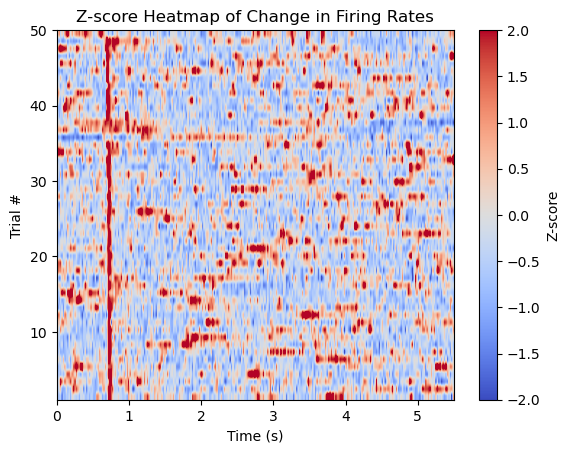

In [87]:
from scipy.stats import zscore
from scipy.stats import zmap

# Z-score the change in firing rates
z_scored_change = zscore(change_in_firing_rates, axis=1)
#z_scored_change = zmap(change_in_firing_rates, baseline_firing_rates, axis=0)

# Plotting
time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-2, vmax=2)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = stim_onset
hold_duration = stim_hold
#plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
#plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates')
plt.show()

In [18]:
#y axis is units instead of trials
# Define trial parameters
trial_duration = 5  # seconds
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 172
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(trial_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))  # Adjusted size
stimulation_signal = np.zeros((num_trials, int(sampleRate * trial_duration)))

# Create a dictionary to store firing rates for each unit
unit_firing_rates = {}
unit_baseline_rates = {}

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration) + physio_start_index
    end_index = (i + 1) * int(sampleRate * trial_duration) + physio_start_index

    # # Find indices within the specified range
    # indices_within_range = [i for i, val in enumerate(goodSamples) if start_index <= val <= end_index]

    # # Extract corresponding spike samples and unit IDs for all units
    # trial_spikes_all_units = [goodSpikes[i] for i in indices_within_range]
    # trial_spikes_all_units = np.array(trial_spikes_all_units)

    trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]
    unique_units = np.unique(trial_spikes_all_units)

    # Calculate firing rates for each unit using np.histogram
    for unit_id in unique_units:
        unit_spikes = trial_spikes_all_units[trial_spikes_all_units == unit_id]

        firing_rates, bins = np.histogram(unit_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))
        unit_firing_rates.setdefault(unit_id, []).append(firing_rates[:num_bins])

        # Calculate the average firing rate from 2 seconds to the end
        baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor) - 1:])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
        unit_baseline_rates.setdefault(unit_id, []).append(baseline_firing_rate[:num_bins])

#takes about 1 minute

In [25]:
# Calculate the average change in firing rate for each unit across trials
average_unit_firing_rates = {unit_id: np.mean(unit_rates, axis=0) for unit_id, unit_rates in unit_firing_rates.items()}
average_unit_baseline_rates = {unit_id: np.mean(base_rates, axis=0) for unit_id, base_rates in unit_baseline_rates.items()}

# Convert the dictionary values to a 2D array for plotting
average_change_in_firing_rates = np.array(list(average_unit_firing_rates.values()))
average_change_in_baseline_rates = np.array(list(average_unit_baseline_rates.values()))

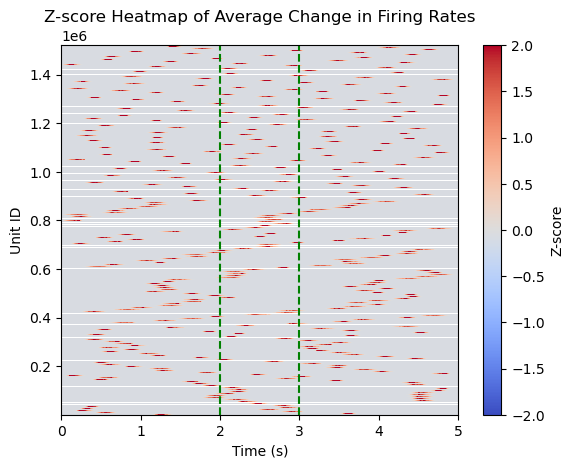

In [26]:
# Z-score the change in firing rates
#z_scored_change = zmap(average_change_in_firing_rates, average_change_in_baseline_rates, axis=0)
z_scored_change = zscore(average_change_in_firing_rates, axis=1)


# Plotting
time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
unit_axis = list(average_unit_firing_rates.keys())

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, len(unit_axis)], cmap='coolwarm', origin='lower', vmin=-2, vmax=2)  # Centered colormap


# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stim_onset + stim_hold , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit ID')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Average Change in Firing Rates')
plt.show()